In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


0-IMPORTING PYTHON PACKAGES AND LIBRARIES

In [2]:
#from devtools import *
#from sp import *
#from raster import *
#from keras import *
#from tensorflow import *
#from spatstat import *
#from magick import *
#from imager import *
#from jpeg import *
#from tibbl import *
#from ggplot2 import *
#from tidyr import *
#from dplyr import *
#from caret import *
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.datasets import mnist 
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


import cv2
import zipfile
#from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import os, math
from urllib.request import urlopen,urlretrieve
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm_notebook
from glob import glob
from sklearn.datasets import load_files   
from sklearn.utils import shuffle
from keras import applications
from keras.utils import np_utils
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization, GaussianNoise
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator 
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from skimage.transform import resize
from sklearn import svm, datasets
from skimage.util import view_as_windows
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels


1-PATH DEFINITION

In [3]:
#Extract Zip
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/BKK/DATASET/dataset_maison.zip"
with ZipFile (file_name,'r') as zip:
  zip.extractall()

#Define the path for the dataset folder

path = '/content' #file directory
path_dataset = (path + '/dataset_maison') #dataset directory

In [4]:
#Define the path for the dataset sub-folders

path_train = (path_dataset + '/training')
path_val = (path_dataset + '/validation')
path_test = (path_dataset + '/test')

print('Done')

Done


2-PRE DEFINITION OF THE MODEL

In [5]:
#Keras sorts the labels (names of folders in the train directory) by alphabetical order.

num_classes=2
class_names = ('a_maison', 'others')

In [6]:
# parameters layers
filters_1= 64
filters_2= 64
filters_3= 64
filters_4= 64
filters_dense = 64
size = 64
kernel_size = (3, 3)
pool_size = 2
rate = 0.4
#mean = 0
batch_size = 256 #batch_size to train
nb_epoch  = 100
learning_rate  = 0.0001
img_rows, img_cols = 64, 64

print('Done')

Done


3-DATA AUGMENTATION

In [7]:
# Artificially improving the dataset with image data generator (rotating images to artificially generate more dataset)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1/255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = True,
  fill_mode = "nearest"
  )

test_datagen = ImageDataGenerator(rescale=1./255)  

train_generator = train_datagen.flow_from_directory(
    directory= path_train,              #target directory 
    target_size=(size, size),           #resizes all images
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)
  
validation_generator = test_datagen.flow_from_directory(
    directory= path_val,
    target_size=(size,size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42) #Batch size is done by default by keras

test_generator = test_datagen.flow_from_directory(
    directory= path_test,
    target_size=(size, size),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=True)

labels = train_generator.class_indices
#label_nb = np.size(list((labels.values())))
label_nb = train_generator.num_classes # is the same
#label_names = list((labels.keys()))
num_classes = label_nb

Found 995587 images belonging to 2 classes.
Found 213339 images belonging to 2 classes.
Found 213339 images belonging to 2 classes.


4-DEFINING THE MODEL (NUMBER OF LAYERS AND PARAMETERS)

In [8]:
##Creation of Layers
model = Sequential()                #Model creation

##LAYER 1##
layer1 = Conv2D(filters = filters_1, kernel_size= kernel_size, input_shape = (size, size, 3), activation = 'relu')
model.add(layer1)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= pool_size ))
#model.add(Dropout(rate))

##LAYER 2##
layer2 = Conv2D(filters = filters_2, kernel_size = kernel_size, activation = 'relu')
model.add(layer2)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= pool_size ))
#model.add(Dropout(rate))

##LAYER 3##
layer3 = Conv2D(filters = filters_3, kernel_size = kernel_size, activation = 'relu')
model.add(layer3)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= pool_size ))
#model.add(Dropout(rate))

##LAYER 4##
layer4 = Conv2D(filters = filters_4, kernel_size = kernel_size, activation = 'relu')
model.add(layer4)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= pool_size ))
#model.add(Dropout(rate))
model.add(Flatten())

##LAYER 5##
layer5 = Dense(filters_dense,activation = "relu", kernel_regularizer = tf.keras.regularizers.l1(0.01))
model.add(layer5)
model.add(BatchNormalization())
model.add(Dropout(rate))

##LAYER 6##
#layer6 = Dense(filters_dense,activation = "relu", kernel_regularizer = tf.keras.regularizers.l1(0.01))
#model.add(layer6)
#model.add(BatchNormalization())
#model.add(Dropout(rate))

##LAYER 7##
layer7=Dense(units = num_classes, activation = 'softmax')     # units: number of nodes in the layer
model.add(layer7)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                        

5-MODEL TRAINING

In [ ]:
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Early stopping the model training when the model is stable enough
from keras.callbacks import EarlyStopping

#Plot
speed = 1
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size//speed
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size//speed
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

#Callback
callback = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 8, #Number of epochs after minimum
                          verbose = 1,
                          restore_best_weights = True)

#Model training
h = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=nb_epoch, 
                    callbacks = [callback])
import time
#end = time.time()
#print(end - start)
#print(learning_rate)

path_base = '/content/drive/MyDrive/BKK/IA'
path_result = path_base + '/RESULTS'
list = os.listdir(path_result)
nb_test = len(list) #We take a look at the number of tests already existing in the destination folder
test_name = 'GN'+ str(nb_test+1) + '_' + class_names[0] + '_' + class_names[1] + '_filters_' + str(filters_1) + '_batch-size_' + str(batch_size) #We assign a new number to the current test
index = 1 #index for the part 9 MAPPING

os.mkdir(path_result+'/'+test_name)
path_test = path_result+'/'+test_name
model.save_weights(path_test + '/'  + test_name + '_weights.h5')
model.save(path_test + '/'  + test_name + '_model.h5')
print('Done')

Epoch 1/100
3889/3889 [==============================] - 2053s 527ms/step - loss: 2.2870 - accuracy: 0.8116 - val_loss: 0.3953 - val_accuracy: 0.8467
Epoch 2/100
3889/3889 [==============================] - 1829s 470ms/step - loss: 0.3485 - accuracy: 0.8688 - val_loss: 0.3408 - val_accuracy: 0.8683
Epoch 3/100
3889/3889 [==============================] - 1648s 424ms/step - loss: 0.3154 - accuracy: 0.8826 - val_loss: 0.2789 - val_accuracy: 0.8965
Epoch 4/100
3889/3889 [==============================] - 1613s 415ms/step - loss: 0.2984 - accuracy: 0.8894 - val_loss: 0.2681 - val_accuracy: 0.9015
Epoch 5/100
3889/3889 [==============================] - 1637s 421ms/step - loss: 0.2824 - accuracy: 0.8961 - val_loss: 0.3181 - val_accuracy: 0.8841
Epoch 6/100
3889/3889 [==============================] - 1591s 409ms/step - loss: 0.2722 - accuracy: 0.9006 - val_loss: 0.4370 - val_accuracy: 0.8529
Epoch 7/100
3889/3889 [==============================] - 1605s 413ms/step - loss: 0.2642 - accuracy:

6-CREATION OF A RESULTS FOLDER


In [9]:
import time
#end = time.time()
#print(end - start)
#print(learning_rate)
class_names = ['maison','others']
path_base = '/content/drive/MyDrive/BKK/IA'
path_result = path_base + '/RESULTS'
list = os.listdir(path_result)
nb_test = len(list) #We take a look at the number of tests already existing in the destination folder
test_name = 'GN'+ str(nb_test+1) + '_' + class_names[0] + '_' + class_names[1] + '_filters_' + str(filters_1) + '_batch-size_' + str(batch_size) #We assign a new number to the current test
index = 1 #index for the part 9 MAPPING

os.mkdir(path_result+'/'+test_name)
path_test = path_result+'/'+test_name
model.save_weights(path_test + '/'  + test_name + '_weights.h5')
model.save(path_test + '/'  + test_name + '_model.h5')
print('Done')

Done


7-EVALUATION OF THE TRAINING LOSS AND ACCURACY ON THE DATASET

In [ ]:
model = load_model('/content/drive/MyDrive/BKK/IA/RESULTS/GN18_a_maison_others_filters_512_batch-size_256/GN18_a_maison_others_filters_512_batch-size_256_model.h5')

N = len(h.history['accuracy']) #N is the number of epochs considering the early stopping
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), h.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), h.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
# plt.savefig(path_test + '/'  + test_name + '_1.png')

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), h.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
# plt.savefig(path_test + '/'  + test_name +  '_2.png')

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), h.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), h.history["val_accuracy"], label="val_accuracy")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
# plt.savefig(path_test + '/'  + test_name + '_3.png')

NameError: ignored

8-CONFUSION MATRIX & CLASSIFICATION REPORT

In [ ]:
model = load_model('/content/drive/MyDrive/BKK/IA/RESULTS/GN18_a_maison_others_filters_512_batch-size_256/GN18_a_maison_others_filters_512_batch-size_256_model.h5')

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

#Evaluate
test_generator.reset()
scores = model.evaluate(test_generator, steps= test_generator.samples, verbose=1)
print("Test Accuracy = %.2f%%" % (scores[1]*100))

#Predict
y_pred = model.predict(test_generator, steps = test_generator.samples, verbose=1)
y_pred = np.argmax(y_pred, axis=-1)
y_true = test_generator.classes[test_generator.index_array]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, y_pred)
#print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred, average='macro')
#print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred, average='macro')
#print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred,average='macro')
#print('F1 score: %f' % f1)

data_label = ['Accuracy: ', 'Precision:' ,'Recall:', 'F1 Score:']
data = [ accuracy, precision,recall,f1]
param_label = ['Learning Rate:', 'Batch Size:','Nombre d époches:', 'Filter_1:','Filter_2:','Filter_3:','Filter_4:','Pool Size:', 'Dropout Rate:']
param = [learning_rate,batch_size,N,filters_1,filters_2,filters_3,filters_4,pool_size,rate]
score = pd.DataFrame({'jhv':data_label,'jhvh':data})
param = pd.DataFrame({'jhvf':param_label,'jhcv':param})
df_score=pd.DataFrame(score)
df_param=pd.DataFrame(param)
df_tot = pd.concat([df_score, df_param], ignore_index=True, axis=1)
# df_tot.to_csv (path_test +'/valeurs_' + test_name + '.csv', index = False, header=True)   
# mettre les valeurs dans deux colonnes différentes 
print (df_tot)

# Confusion Matrix and Classification Repport
target_names=['maison','others']

from sklearn.metrics import confusion_matrix, classification_report
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print('Classification Report')

#This function prints and plots the confusion matrix.
#Normalization can be applied by setting `normalize=True`.
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig

np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
fig = plot_confusion_matrix(test_generator.classes[test_generator.index_array],y_pred, classes = target_names,
                      normalize = True, title='Normalized Confusion matrix')
# fig.savefig(path_test + '/' + test_name + '_CM.png')   

NameError: ignored

9-PREDICTION AND MAPPING

Treating image number 1 ...
Image number 1 treated.
Treating image number 2 ...
Image number 2 treated.
Treating image number 3 ...
Image number 3 treated.
Treating image number 4 ...
Image number 4 treated.
Treating image number 5 ...
Image number 5 treated.
Treating image number 6 ...
Image number 6 treated.
Treating image number 7 ...
Image number 7 treated.


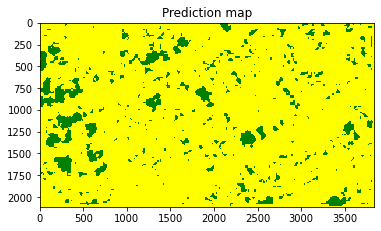

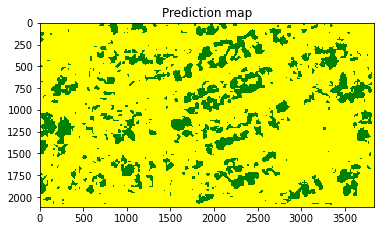

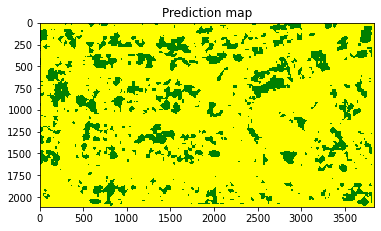

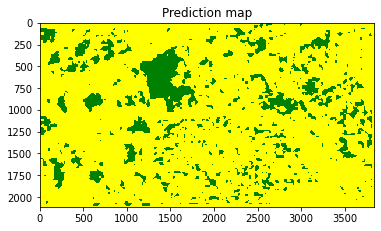

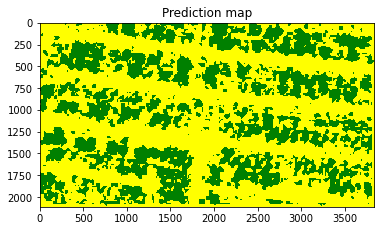

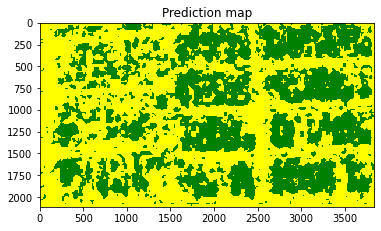

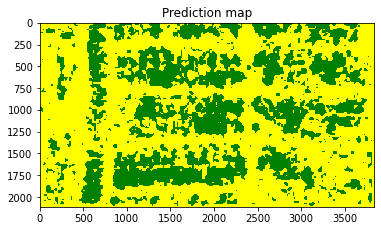

In [10]:
window_width, window_heigth  = 64, 64 
overlap = 16 #must be a factor for window_width, window_heigth

model = load_model('/content/drive/MyDrive/BKK/IA/RESULTS/GN18_a_maison_others_filters_512_batch-size_256/GN18_a_maison_others_filters_512_batch-size_256_model.h5')

# Creating a loop to apply the prediction on several images
for l in range(1,8):
  print('Treating image number',l,'...')

  #Opening the image to apply the prediction
  img_tocrop=Image.open('/content/drive/MyDrive/BKK/MAP' + str(l) + '.jpg')
  #img_tocrop = Image.open(path_base +  '/Detection/cropped_image_' + str(l) +'.jpg')


  # cropping the image to predict into a multiple of the window dimensions
  img_w, img_h  = img_tocrop.size
  wrest = img_w%window_width #%=remainder, // = integer
  hrest = img_h%window_heigth
  obj_image = img_tocrop.crop((0, 0, img_w-wrest, img_h-hrest)) 

  # Cut the image in the corresponging proportional piezes
  img_width, img_height  = obj_image.size
  nb_img_width = int(img_width//overlap)
  nb_img_heigth = int(img_height//overlap)
  nb_total = nb_img_width*nb_img_heigth
  obj_subimages = np.zeros((nb_total, window_width*window_heigth*3), dtype = int) 
  obj_subimages = obj_subimages.reshape(nb_total, window_width, window_heigth, 3)

  # Creation of matrixes to make prediction of the subimages
  k=0
  obj_subimages_pred = np.zeros((nb_total, 1), dtype = int)
  obj_subimages_accu = np.zeros((nb_total, 1), dtype = float)

  # Creation of matrixes to collect the prediction values and accuracies
  mapping = np.zeros((img_height, img_width), dtype = int)
  accura = np.zeros((img_height, img_width), dtype = int)     

  for i in range(nb_img_heigth):
      for j in range(nb_img_width):
          box = (j*overlap, i*overlap, window_width + j*overlap, window_heigth + i*overlap)
          cropped = obj_image.crop(box)
          cropped = np.array(cropped)
          obj_subimages[k,:, :, :] = cropped
          
          #Make prediction of the subimages
          x = obj_subimages[k,:,:,:]
          x = np.expand_dims(x, 0)
          y = model.predict(x/255)
          yy = np.argmax(y)
          yyy = round(np.max(y)*100, 2)
          yy_matrix =   yy*np.ones((overlap, overlap), dtype = int)
          yyy_matrix = yyy*np.ones((overlap, overlap), dtype = int)

          #matrixes to collect the prediction values and accuracies
          mapping[i*overlap:i*overlap+overlap,j*overlap:j*overlap+overlap] = yy_matrix   #y1:y2+1, x1:x2+1
          accura[i *overlap:i*overlap+overlap,j*overlap:j*overlap+overlap]  = yyy_matrix
          k += 1
  print('Image number',l,'treated.')

  plt.figure()
  colors = 'green yellow'.split() #canals city forest road
  cmap = matplotlib.colors.ListedColormap(colors, name='colors', N=None)
  plt.imshow(mapping, cmap=cmap, vmin=0, vmax= (num_classes - 1)) #vmin and vmax give the number of colors to use
  plt.title('Prediction map')
  plt.savefig(path_test + '/image_' + str(l) + '_overlap_' + str(overlap) + '_mapping.png')
  pd.DataFrame(mapping).to_csv(path_test + '/matrice_classes_image_' + str(l) + '_overlap_' + str(overlap) + '.csv', index = False, header=False)
  pd.DataFrame(accura).to_csv(path_test  + '/matrice_accu_image_' + str(l) + '_overlap_' + str(overlap) + '.csv', index = False, header=False)
